In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import logging
logging.basicConfig(level=logging.INFO)

from myTorch.task.copying_memory import CopyingMemoryData
from myTorch.memnets.load import load_experiment
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/home/sarath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model = "/mnt/data/sarath/nips/backup/v1/instance4/output/copy_v1_lag_100/fm"

In [5]:
def example_memory(save_dir, time_lag, seed):
    experiment, model, data_iterator, device, config = load_experiment(save_dir)
    config.time_lag = time_lag
    config.batch_size = 1
    config.seed = seed
    new_data_iterator = CopyingMemoryData(seq_len=config.seq_len, time_lag_min=config.time_lag_min,
                                          time_lag_max=config.time_lag_max, num_noise_digits=config.num_noise_digits,
                                          num_digits=config.num_digits,
                                          batch_size=config.batch_size, seed=config.seed)
    data_iterator = new_data_iterator
    
    data = data_iterator.next()
    seqloss = 0

    model.reset_hidden(batch_size=1)

    hiddens = []

    for i in range(0, data["datalen"]):

        x = torch.from_numpy(np.asarray(data['x'][i])).to(device)
        y = torch.from_numpy(np.asarray(data['y'][i])).to(device)
        mask = float(data["mask"][i])

        model.optimizer.zero_grad()

        output = model(x)
        hiddens.append(model._h_prev[0]["memory"])
        if config.task == "copying_memory":
            loss = F.torch.nn.functional.cross_entropy(output, y.squeeze(1))
        else:
            loss = F.binary_cross_entropy_with_logits(output, y)

        seqloss += (loss * mask)

    seqloss /= sum(data["mask"])
    print(seqloss)

    return hiddens
    

INFO:root:using cpu
/mnt/data/sarath/code/myTorch/myTorch/memnets/recurrent_net.py:93: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self._W_h2o, gain=nn.init.calculate_gain(self._output_activation))
/mnt/data/sarath/code/myTorch/myTorch/memnets/recurrent_net.py:94: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self._b_o, 0)
INFO:root:Loading the experiment from /mnt/data/sarath/nips/backup/v1/instance4/output/copy_v1_lag_100/fm


Num_params : 23569 
/mnt/data/sarath/nips/backup/v1/instance4/output/copy_v1_lag_100/fm/current/flag.p
tensor(5345.5181)


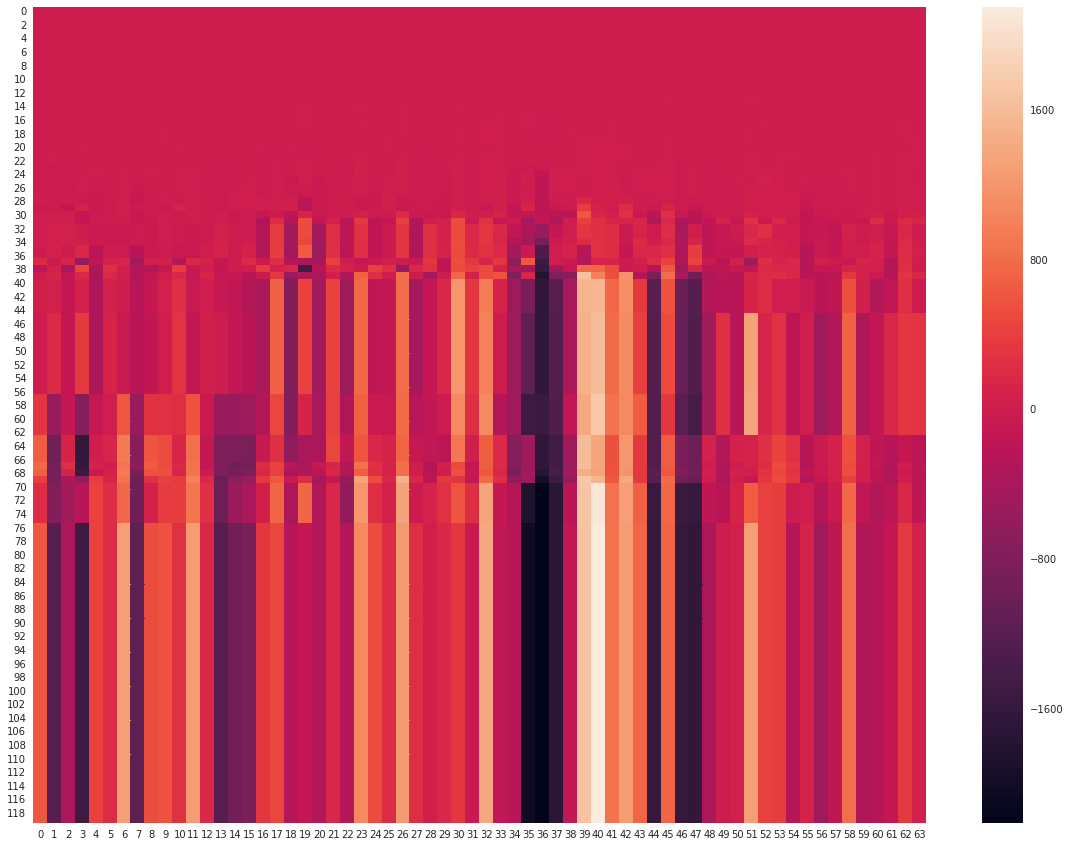

In [6]:
memory = example_memory(model, time_lag = 100, seed=11)

x = len(memory)
y = len(memory[0][0].detach().numpy())

matrix = np.zeros((x,y))
for i in range(0,x):
    matrix[i] = memory[i][0].detach().numpy()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix)


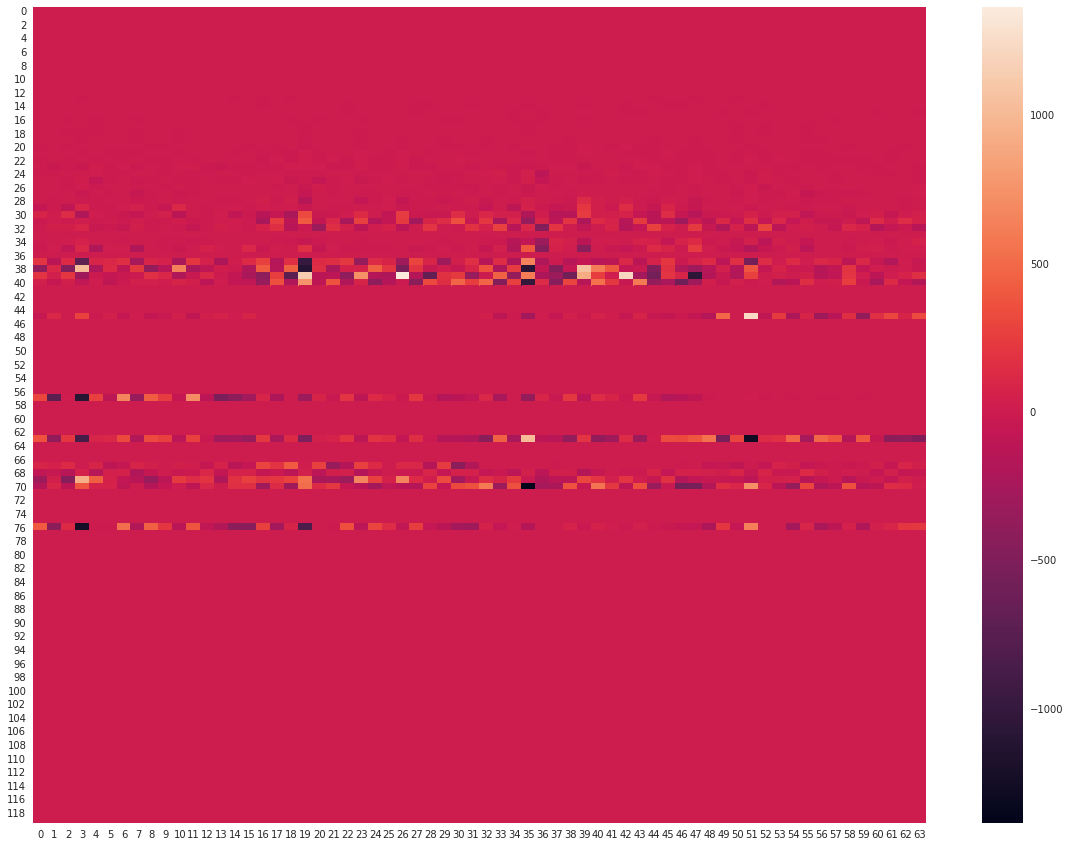

In [7]:
new_matrix = np.zeros((x,y))

for i in range(0,x):
    if i==0:
        new_matrix[i] = matrix[i]
    else:
        new_matrix[i] = matrix[i] - matrix[i-1]
plt.subplots(figsize=(20,15))
ax = sns.heatmap(new_matrix)